# Fine-tuning BERT for emotion detection

The notebook describes the process for training a neural net for emotion recognition from text. I also contains problems we face and a description of the envisioned solution.


------

In short, we (want to) train a neural network based on pre-trained word embeddings overlaid with labelled data we provide (partly from the existing `ISEAR` data set, partly manually annotated sentences).

The desired outcome is multi-class emotion detection: anger, disgust, fear, sadness, joy, and neutral (no emotion).

------

In [ ]:
import os
from pathlib import Path
import pandas as pd

In [ ]:
#os.chdir("C://Users/bantel/switchdrive/WORK/")
# folder should contain # ./data/BERT-in/

In [ ]:
# load isear data
isear = pd.read_csv("data/BERT-in/isear_preprocessed.csv")[["EMOTION", "SITUATION"]].rename(columns = {"EMOTION": "label", "SITUATION": "text"})

## Train Emotion Recognition Model

This section trains a model to recognize emotions from labelled text data (using the ISEAR data set).

**Tokenize**

Transform the text corpus to a vector representation

- **num_words**: Number of words to use

In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
num_words = 10000

tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(isear.text)

tokenizer_path = Path('./code').resolve()
with tokenizer_path.open('wb') as file:
    pickle.dump(tokenizer, file)

**Split data** into training and validation data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data = isear.copy()

train = pd.DataFrame(columns=['label', 'text'])
validation = pd.DataFrame(columns=['label', 'text'])
for label in data.label.unique():
    label_data = data[data.label == label]
    train_data, validation_data = train_test_split(label_data, test_size=0.3)
    train = pd.concat([train, train_data])
    validation = pd.concat([validation, validation_data])

## 2) Build Model
---
The model has (will have) the structure as follows:
- starting with a baseline of a pre-trained embedding space
- overlaid with training data from the ISEAR data set (`isear`)
- overlaid with manually labelled instances (`labelled_cases`)

The output is one of the six cases: `anger`, `disgust`, `fear`, `sadness`, `joy`, and `neutral`.

### 2.1 Define the **LSTM** + **CNN** model

In [ ]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model

In [ ]:
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
num_classes = len(data.label.unique())
embedding_dim = 500
input_length = 100
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3
# consider using pretrained model (BERT or successors) as embedding model

In [ ]:
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 500)     4626000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 500)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 256)     644096      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [5]:
#!pip install pydot
from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Using TensorFlow backend.


### 2.2 Add pre-trained embedding space

In [19]:
# to complete

### 2.3 Add `isear` data

prepare `isear` data

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

In [ ]:
# split into training and testing data
train_sequences = [text.split() for text in train.text]
validation_sequences = [text.split() for text in validation.text]
list_tokenized_train = tokenizer.texts_to_sequences(train_sequences)
list_tokenized_validation = tokenizer.texts_to_sequences(validation_sequences)
x_tr = pad_sequences(list_tokenized_train, maxlen=input_length)
x_test = pad_sequences(list_tokenized_validation, maxlen=input_length)

encoder = LabelBinarizer()
encoder.fit(data.label.unique())

encoder_path = Path('./code_files/ISEAR/emotion_recognition_encoder.pickle')
with encoder_path.open('wb') as file:
    pickle.dump(encoder, file)

y_tr = encoder.transform(train.label)
y_test = encoder.transform(validation.label)

# from training data, reserve cases for validation [X_train, X_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size=0.1, random_state=42)]

### 2.4 Add `labelled_cases`

In [ ]:
# load labelled_cases
labelled_cases = pd.read_csv("./BERT-in/House_of_commons_2019ff_labelled_test.csv", index_col=0)

In [ ]:
# include in pipeline

## Train model

Do the training process with the given data

In [ ]:
batch_size = 128
epochs = 2 # 5 for overview

In [18]:
fitted_model = model.fit(
    x_tr,
    y = y_tr,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_test, y_test)
)

# fits the model (affecting object "model") and saves the "history" of the saving process in fitted_model

Train on 5364 samples, validate on 2302 samples
Epoch 1/2
5364/5364 [==============================] - 133s 25ms/sample - loss: 1.9241 - acc: 0.1959 - val_loss: 1.8500 - val_acc: 0.2624
Epoch 2/2
5364/5364 [==============================] - 138s 26ms/sample - loss: 1.5400 - acc: 0.4277 - val_loss: 1.4066 - val_acc: 0.4913


## 4) Save Model & Weights

In [ ]:
model_path = Path('./code_files/ISEAR/model').resolve() # creates model file
#model.save(model_path)

In [ ]:
model_weight_path = Path('./code_files/ISEAR/model_weights.h5').resolve()
#model.save_weights(model_weight_path.as_posix())

# 5) Evaluate Model

Evaluate the model (accuracy).

In [19]:
score = model.evaluate(x_test, y_test, verbose = 0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4065573001094325
Test accuracy: 0.4913119


In [21]:
fitted_model.history

{'loss': [1.9240910213087852, 1.5399531470938106],
 'acc': [0.19593588, 0.42766592],
 'val_loss': [1.8500090580624564, 1.4065573019736959],
 'val_acc': [0.26238054, 0.4913119]}

To increase accuracy, adjust the hyperparamets above (number of filters, kernel size, dropout rate, ...) or the number of layers.

In [22]:
fitted_model.history['val_loss']

[1.8500090580624564, 1.4065573019736959]

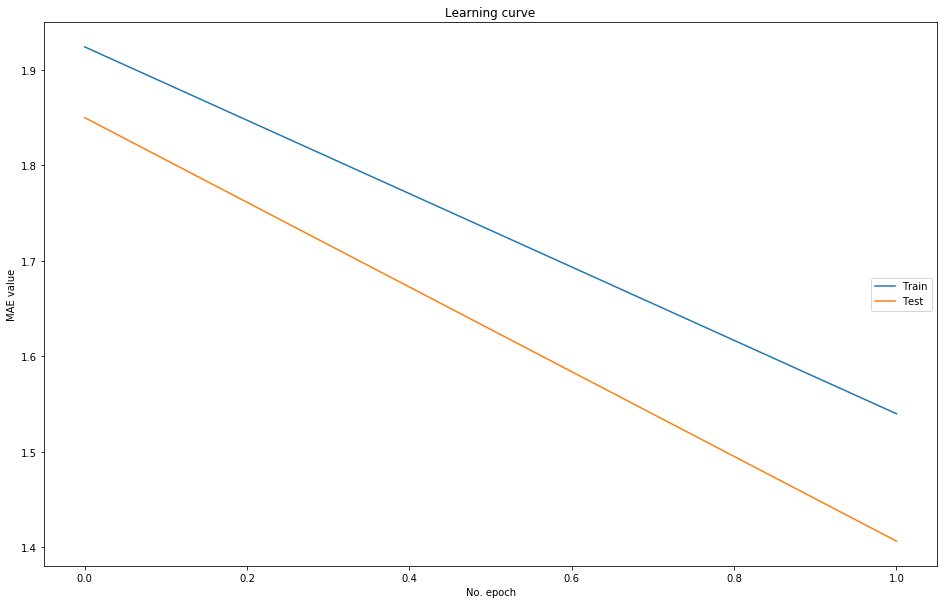

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.plot(fitted_model.history['loss'], label='Train')
plt.plot(fitted_model.history['val_loss'], label='Test')
plt.title('Learning curve')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="right")
plt.show()

In [ ]:
# => minimal MAE value -> 2 epochs? plot accuracy (maximize for test set acc.)
# ==> overfitting!

In [23]:
# layer = model.layers[2]
# w = layer.get_weights()
# plt.imshow(w)

for layer in model.layers:
    print(layer.name)
    if layer.name == "conv2d_8":
        w = layer.get_weights()
        print(layer.name, " ", w[0].shape)
        plt.figure()
        plt.imshow(w[0].reshape(8,36))
        plt.show()

# plt.imshow(w[0][:,:,0,0], )

input_1
embedding
spatial_dropout1d
bidirectional
conv1d
global_average_pooling1d
global_max_pooling1d
concatenate
dense


In [30]:
# insert loop: predictions, retrieve to_predict, re-train, etc.

---

# Predict emotions on unseen data

This section applies the previously trained model to new data to predic emotions

## 1) Preparation

**Load tokenizer** from pickle file

In [29]:
with tokenizer_path.open('rb') as file:
    tokenizer = pickle.load(file)

**Load model** for emotion recognition trained previously

In [ ]:
### <not run?> ###

In [ ]:
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
num_classes = 4
embedding_dim = 500
input_length = 100
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout = 0.2
filters = 64
kernel_size = 3

In [ ]:
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)

In [ ]:
### </not run?> ###

In [30]:
import tensorflow as tf
model = tf.keras.models.load_model(model_path)
model.load_weights(model_weight_path.as_posix())

**Load data**

Load the data on which we want to perform predictions with the model (`data_path`: Path to the .csv file containing the texts to predict).

In [9]:
data_path = Path("./BERT-in/House_of_commons_2019ff_to_predict.csv").resolve()

data = pd.read_csv(data_path)#, index_col=0).drop(columns = ["text"])
#data.head()

#	id						date 					user		 	text
#0 	1151893341782585349 	2019-07-18 16:35:48 	Ozzzylot	 	⚡️ Fans share what Kyoto Animation studio mean...
#1 	1151893322908102657 	2019-07-18 16:35:43 	rosyutori 		Deep condolences to all who are passed away at...
#2 	1151893318101377024 	2019-07-18 16:35:42 	met_bit 		Striking news... How on earth can someone be s...
#3 	1151893304117813248 	2019-07-18 16:35:39 	Destructo_Dan 	I don’t know if I had any favorite anime from ...
#4 	1151893302863650816 	2019-07-18 16:35:39 	KDiscavage 		The news about Kyoto Animation Studios hit me ...

subset data for predictions: only predict on data with high subjectivity scores (TextBlob)

In [10]:
#data.loc[(data["flair"] < -.5)|(data['flair'] > .5), :]
data_pred = data.loc[(data["txtblob_subjectivity"] > .3), :]
#data['txtblob_subjectivity'].hist()

In [11]:
print(data_pred.shape[0] / data.shape[0], data.shape[0])

0.636 1000


**Load Encoder**

Load .pickle file with the encoder

In [ ]:
with encoder_path.open('rb') as file:
    encoder = pickle.load(file)

**Preprocess data**

Preprocess the data that will be used

In [ ]:
#from nlp import preprocess
import nltk
nltk.download('stopwords')

In [ ]:
#data_pred.reset_index().rename(columns={"index": "id"}).drop(columns = ["agenda"]).head()

In [ ]:
data_pred['split'] = data_pred['sentences'].apply(lambda x: x.split()) # sequences
data_pred['list_tokenized'] = tokenizer.texts_to_sequences(data_pred['split']) # list_tokenized

x_data_pred = pd.DataFrame(data = pad_sequences(data_pred['list_tokenized'], maxlen=100), # x_data
                           columns = ["pad_seq_" + str(i).zfill(2) for i in range(100)],
                           index=data_pred.reset_index()["index"])

In [74]:
data_pred.head()

date                                             agenda  \
2  2018-09-04  Official Development Assistance: Endangered Sp...   
3  2018-09-04  Official Development Assistance: Endangered Sp...   
4  2018-09-04  Official Development Assistance: Endangered Sp...   
7  2018-09-04  Official Development Assistance: Endangered Sp...   
8  2018-09-04  Official Development Assistance: Endangered Sp...   

   speechnumber            speaker party  party.facts.id  chair  terms  \
2             3  Ranil Jayawardena   Con            1567  False     56   
3             3  Ranil Jayawardena   Con            1567  False     56   
4             3  Ranil Jayawardena   Con            1567  False     56   
7             4   Harriett Baldwin   Con            1567  False     61   
8             6   Harriett Baldwin   Con            1567  False     89   

          parliament iso3country  ...  PERSON  PM BJ  TM  BJ_PM  TM_PM  \
2  UK-HouseOfCommons         GBR  ...   False   0  0   0      0      0   
3  UK-HouseOfCommons         GBR  ...   False   1  0   0      0      1   
4  UK-HouseOfCommons         GBR  ...   False   0  0   0      0      0   
7  UK-HouseOfCommons         GBR  ...   False   0  0   0      0      0   
8  UK-HouseOfCommons         GBR  ...   False   0  0   0      0      0   

   month_year  TM_BJ_01                                              split  \
2     2018-09       NaN                     [Welcome, back,, Mr, Speaker.]   
3     2018-09       May  [I, welcome, the, Prime, Minister's, announcem...   
4     2018-09       NaN  [Would, my, Friend, the, Minister, also, like,...   
7     2018-09       NaN  [While, I, was, out, there, I, announced, a, p...   
8     2018-09       NaN  [I, did, see, reports, of, that, very, unfortu...   

                                      list_tokenized  
2                                       [3993, 2279]  
3  [1, 3993, 3, 7683, 4179, 143, 252, 13, 3283, 2...  
4  [54, 5, 22, 3, 7684, 201, 132, 4, 100, 186, 26...  
7  [95, 1, 7, 38, 63, 1, 1025, 2, 1188, 13, 6598,...  
8                      [1, 36, 100, 1964, 9, 13, 21]  

[5 rows x 36 columns]

**Results**

Predict the labels and generate a confusion matrix

In [75]:
import numpy as np

In [78]:
y_predictions_raw = model.predict(x_data_pred)

In [83]:
predictions_df = pd.DataFrame(data = y_predictions_raw, columns=encoder.classes_, 
                              index=x_data_pred.reset_index()["index"])

In [84]:
print("Overview:")
for index, value in enumerate(np.sum(y_predictions_raw, axis=0) / len(y_predictions_raw)):
    print(f"   {100 * value:.2f}% overall {encoder.classes_[index]}.")

Overview:
   12.85% overall ANGER.
   19.80% overall DISGUST.
   16.12% overall FEAR.
   8.40% overall GUILT.
   9.68% overall JOY.
   16.46% overall SADNESS.
   16.68% overall SHAME.


In [91]:
data_predicted = pd.merge(data, predictions_df, how="outer", left_index=True, right_index=True)

In [ ]:
#data_predicted = pd.merge(data, predictions_df, left_index=True, right_index=True)

save_predictions_path = Path("./BERT-out/House_of_commons_predicted.csv").resolve()

data_predicted.to_csv(save_predictions_path)

In [63]:
y_pred_argmax = y_pred.argmax(axis=1)
data_len = len(y_pred_argmax)
for index, value in enumerate(np.unique(y_pred_argmax)):
    print(encoder.classes_[index] + ": " + str(len(y_pred_argmax[y_pred_argmax == value]) / data_len))

#angry: 0.09889558232931726
#fear: 0.4011044176706827
#joy: 0.030622489959839357
#sadness: 0.46937751004016065

ANGER: 0.1
DISGUST: 0.3
FEAR: 0.1
GUILT: 0.1
JOY: 0.1
SADNESS: 0.3


In [ ]:
y_pred[5:10].argmax(axis=1)
# array([3, 3, 3, 3, 3])

In [ ]:
data["sentences"].iloc[6]
# 'My heart goes out to the people who died in the fire at Kyoto Animation Studio. \n\n#PrayForKyoani https://t.co/Jvg9R8f6Oc'

# Validate predictions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

save_predictions_path = Path("./BERT-out/House_of_commons_predicted.csv").resolve()

data_predicted = pd.read_csv(save_predictions_path, index_col = 0).drop(
    columns = ['agenda', 'speechnumber', 'speech_id',
       'sentence_nr', 'vader_neg', 'vader_neu', 'vader_pos', 'terms',
       'vader_compound', 'txtblob_polarity', 'txtblob_subjectivity', 'flair', 'chair',
       'speech_id.1', 'ners', 'entities', 'ORG', 'NORP', 'GPE', 'PERSON', 'PM', "party.facts.id",
       'BJ', 'TM', 'BJ_PM', 'TM_PM', 'TM_BJ_01', 'parliament', 'iso3country', 'month_year'])

In [ ]:
prediction_rows = data_predicted.loc[data_predicted['JOY'].notna(), :]

In [ ]:
#prediction_rows.nlargest(10, columns=["JOY"])[["date", "speaker", "party", "sentences"]]

In [ ]:
top_dataframes = pd.DataFrame()


for emotion in ["ANGER", "DISGUST", "FEAR", "GUILT", "JOY", "SADNESS", "SHAME"]:
    top_n = prediction_rows.nlargest(10, columns=[emotion])[["date", "speaker", "party", "sentences"]]
    top_n["Emotion"] = emotion
    top_dataframes = pd.concat([top_dataframes, top_n])

In [ ]:
save_predictions_validation_path = Path("./BERT-out/House_of_commons_validation.csv").resolve()

top_dataframes[['sentences', 'Emotion']].to_csv(save_predictions_validation_path)